# Start here - Use UniProtein



In [25]:
# First cell - Installation commands
!pip install fair-esm
!pip install torch
!apt-get update
!apt-get install -y mafft
!pip install biopython requests

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,555 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,628 kB]
Fetched 11.2 MB in 2s (5,682 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main

In [26]:
import requests
from Bio import AlignIO, Phylo, SeqIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import subprocess
import tempfile
from google.colab import files
import matplotlib.pyplot as plt
import io
import os
import urllib3
from io import StringIO
import urllib.parse

import esm
import torch

# MAFFT

- use Multiple Alignment FFT to align protein sequences
- use identity distance metric
- use NJ algorithm for neighbor joining

In [29]:
def fetch_uniprot_sequences(keyword, max_sequences=50):
    """Download sequences from UniProt for a given protein family"""
    # Encode the query properly for UniProt API
    encoded_keyword = urllib.parse.quote(keyword)

    # UniProt REST API URL
    url = f"https://rest.uniprot.org/uniprotkb/search?query={encoded_keyword}&format=fasta&size={max_sequences}"

    try:
        print(f"Fetching from URL: {url}")
        response = requests.get(url)

        if response.status_code == 200:
            # Check if we got any sequences
            if len(response.text.strip()) == 0:
                raise ValueError("No sequences found in the response")

            # Save sequences to a FASTA file
            with tempfile.NamedTemporaryFile(mode='w', suffix='.fasta', delete=False) as temp_file:
                temp_file.write(response.text)
                return temp_file.name
        else:
            print(f"HTTP Status Code: {response.status_code}")
            print(f"Response content: {response.text[:200]}")  # Print first 200 chars of response
            raise ValueError(f"Failed to fetch sequences: Status code {response.status_code}")

    except Exception as e:
        print(f"Error during download: {str(e)}")
        raise

def realign_sequences(fasta_file):
    """Realign sequences using MAFFT"""
    output_file = fasta_file.replace('.fasta', '_aligned.fasta')

    cmd = ['mafft', '--auto', fasta_file]
    try:
        result = subprocess.run(cmd,
                              capture_output=True,
                              text=True,
                              check=True)

        with open(output_file, 'w') as handle:
            handle.write(result.stdout)

        return output_file

    except subprocess.CalledProcessError as e:
        print(f"MAFFT alignment failed: {e}")
        print(f"MAFFT error output: {e.stderr}")
        raise
    except Exception as e:
        print(f"An error occurred while running MAFFT: {e}")
        raise

def build_phylogenetic_tree(aligned_fasta):
    """Build phylogenetic tree using distance-based method"""
    try:
        # Read the alignment
        alignment = AlignIO.read(aligned_fasta, 'fasta')
        print(f"Successfully read alignment with {len(alignment)} sequences")

        # Calculate distance matrix using 'identity' model
        calculator = DistanceCalculator('identity')
        print("Calculating distance matrix...")
        dm = calculator.get_distance(alignment)

        print("Building tree using Neighbor-Joining (NJ) method...")
        constructor = DistanceTreeConstructor(calculator)  # No need to specify method here
        tree = constructor.nj(dm)  # Use the nj method

        return tree

    except Exception as e:
        print(f"Error in build_phylogenetic_tree: {str(e)}")
        print(f"Error type: {type(e)}")
        raise

def visualize_tree(tree, title):
    """Create and display a matplotlib figure of the tree"""
    #plt.figure(figsize=(20, 20))
    # Fix the font size issue by setting rcParams
    #plt.rcParams['font.size'] = 8

    #Phylo.draw(tree,
               #do_show=False,
               #label_func=lambda x: x.name[:30])  # Trim long names

    #plt.title(title, fontsize=14)
    #plt.axis('off')
    #plt.tight_layout()
    #plt.show()

    # Step 4: Visualize the tree (north-south layout)
    fig, ax = plt.subplots(figsize=(10, 15))  # Adjust figure size for better visibility
    Phylo.draw(tree, axes=ax, do_show=False)  # Draw the tree on the axes
    ax.invert_yaxis()  # Flip the tree to make it grow from top to bottom
    plt.title("MAFFT Alignment - Identity Distance", fontsize=16)
    plt.show()

def analyze_protein_family(keyword, title):
    """Main workflow function with sequence saving"""
    try:
        # Download sequences
        print(f"Downloading sequences for {keyword}...")
        fasta_file = fetch_uniprot_sequences(keyword)

        # Save a copy of the original sequences
        original_sequences_file = f"{title.replace(' ', '_')}_sequences.fasta"
        with open(fasta_file, 'r') as source:
            with open(original_sequences_file, 'w') as dest:
                dest.write(source.read())

        # Print sequence information
        sequences = list(SeqIO.parse(fasta_file, "fasta"))
        print(f"\nNumber of sequences downloaded: {len(sequences)}")
        print("\nSequence IDs:")
        for seq in sequences:
            print(f"{seq.id}: {seq.description}")

        # Download the original sequences
        files.download(original_sequences_file)

        print(f"\nOriginal sequences saved to: {original_sequences_file}")

        if len(sequences) < 3:
            print("Not enough sequences found for analysis")
            return

        # Realign using MAFFT
        print("\nRealigning sequences...")
        aligned_file = realign_sequences(fasta_file)

        # Build tree
        print("\nBuilding phylogenetic tree...")
        tree = build_phylogenetic_tree(aligned_file)

        # Save tree to Newick format
        safe_filename = "".join(x for x in keyword if x.isalnum() or x in "._- ")
        tree_file = f"{safe_filename}_tree.newick"
        Phylo.write(tree, tree_file, 'newick')
        print(f"\nTree saved as {tree_file}")

        # Visualize tree
        print("\nGenerating tree visualization...")
        visualize_tree(tree, title)

        # Download files
        print("\nPreparing files for download...")
        files.download(tree_file)
        files.download(aligned_file)

        # Cleanup
        if os.path.exists(fasta_file):
            os.remove(fasta_file)

    except Exception as e:
        print(f"Error: {str(e)}")


Analyzing Globin Family Tree...
Fetching from URL: https://rest.uniprot.org/uniprotkb/search?query=protein_name%3Aglobin%20AND%20reviewed%3Atrue&format=fasta&size=50

Number of sequences downloaded: 50

Sequence IDs:
sp|P02100|HBE_HUMAN: sp|P02100|HBE_HUMAN Hemoglobin subunit epsilon OS=Homo sapiens OX=9606 GN=HBE1 PE=1 SV=2
sp|P02042|HBD_HUMAN: sp|P02042|HBD_HUMAN Hemoglobin subunit delta OS=Homo sapiens OX=9606 GN=HBD PE=1 SV=2
sp|P02008|HBAZ_HUMAN: sp|P02008|HBAZ_HUMAN Hemoglobin subunit zeta OS=Homo sapiens OX=9606 GN=HBZ PE=1 SV=2
sp|P69905|HBA_HUMAN: sp|P69905|HBA_HUMAN Hemoglobin subunit alpha OS=Homo sapiens OX=9606 GN=HBA1 PE=1 SV=2
sp|P09105|HBAT_HUMAN: sp|P09105|HBAT_HUMAN Hemoglobin subunit theta-1 OS=Homo sapiens OX=9606 GN=HBQ1 PE=1 SV=2
sp|Q12800|TFCP2_HUMAN: sp|Q12800|TFCP2_HUMAN Alpha-globin transcription factor CP2 OS=Homo sapiens OX=9606 GN=TFCP2 PE=1 SV=2
sp|P68871|HBB_HUMAN: sp|P68871|HBB_HUMAN Hemoglobin subunit beta OS=Homo sapiens OX=9606 GN=HBB PE=1 SV=2
sp|Q2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Original sequences saved to: Globin_Family_Tree_sequences.fasta

Realigning sequences...

Building phylogenetic tree...
Successfully read alignment with 50 sequences
Calculating distance matrix...
Building tree using Neighbor-Joining (NJ) method...

Tree saved as protein_nameglobin AND reviewedtrue_tree.newick

Generating tree visualization...


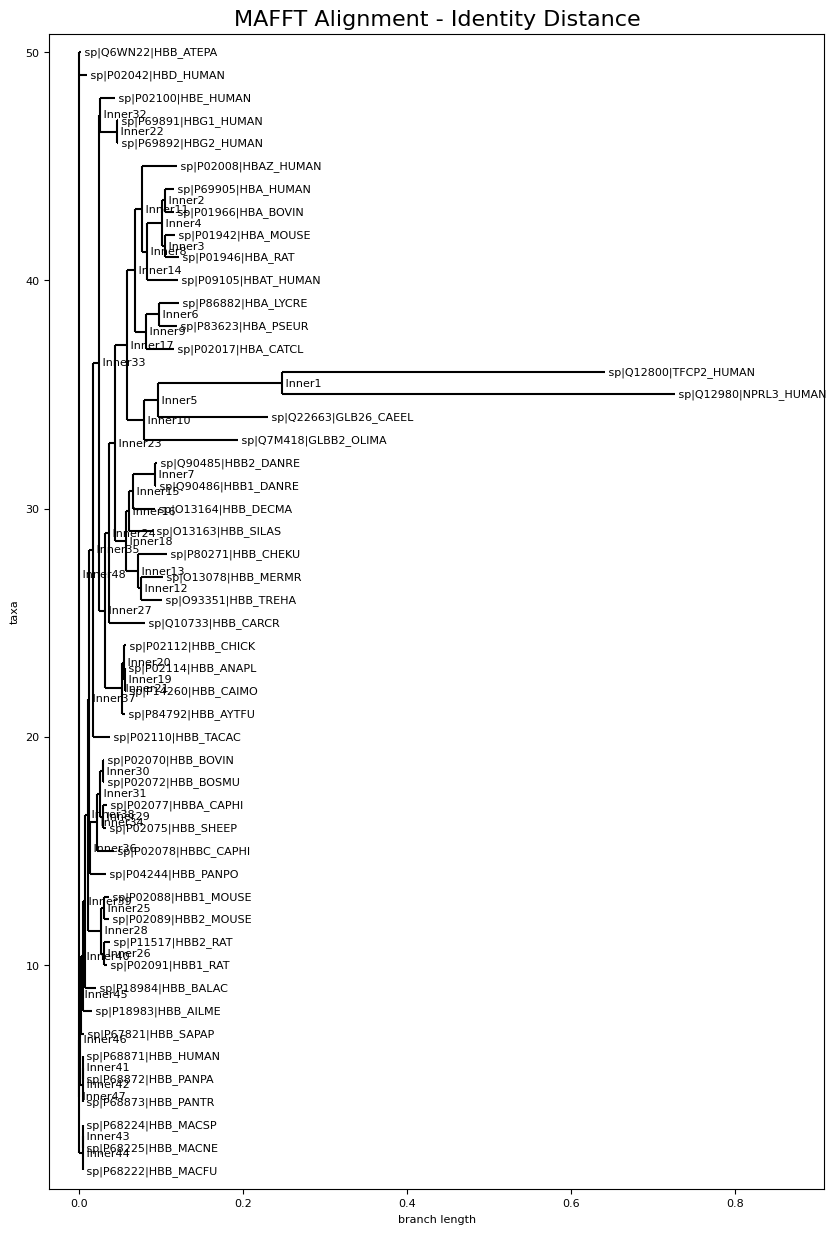


Preparing files for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Analyze different protein families using correct UniProt search syntax
protein_families = [
    ("protein_name:globin AND reviewed:true", "Globin Family Tree"),
    ("protein_name:insulin receptor kinase AND reviewed:true", "Insulin Receptor Kinase Tree"),
    ("gene:RAS AND reviewed:true", "Ras Family Tree")
]

# Let's try just one family first to make sure it works
keyword, title = protein_families[0]  # Try with globin first
print(f"\nAnalyzing {title}...")
analyze_protein_family(keyword, title)

In [31]:
from Bio import SeqIO

# To print sequences from a specific FASTA file
file_name = "Globin_Family_Tree_sequences.fasta"  # or whatever your file is named

# Print all sequences with their IDs and sequences
print("Printing sequences from", file_name)
for record in SeqIO.parse(file_name, "fasta"):
    print("\nSequence ID:", record.id)
    print("Description:", record.description)
    print("Sequence:", record.seq)
    print("Length:", len(record.seq))
    print("-" * 50)

# Or if you want just the first few sequences:
print("\nFirst 3 sequences:")
for i, record in enumerate(SeqIO.parse(file_name, "fasta")):
    if i < 3:  # Only print first 3
        print("\nSequence ID:", record.id)
        print("Sequence:", record.seq)
    else:
        break

Printing sequences from Globin_Family_Tree_sequences.fasta

Sequence ID: sp|P02100|HBE_HUMAN
Description: sp|P02100|HBE_HUMAN Hemoglobin subunit epsilon OS=Homo sapiens OX=9606 GN=HBE1 PE=1 SV=2
Sequence: MVHFTAEEKAAVTSLWSKMNVEEAGGEALGRLLVVYPWTQRFFDSFGNLSSPSAILGNPKVKAHGKKVLTSFGDAIKNMDNLKPAFAKLSELHCDKLHVDPENFKLLGNVMVIILATHFGKEFTPEVQAAWQKLVSAVAIALAHKYH
Length: 147
--------------------------------------------------

Sequence ID: sp|P02042|HBD_HUMAN
Description: sp|P02042|HBD_HUMAN Hemoglobin subunit delta OS=Homo sapiens OX=9606 GN=HBD PE=1 SV=2
Sequence: MVHLTPEEKTAVNALWGKVNVDAVGGEALGRLLVVYPWTQRFFESFGDLSSPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFSQLSELHCDKLHVDPENFRLLGNVLVCVLARNFGKEFTPQMQAAYQKVVAGVANALAHKYH
Length: 147
--------------------------------------------------

Sequence ID: sp|P02008|HBAZ_HUMAN
Description: sp|P02008|HBAZ_HUMAN Hemoglobin subunit zeta OS=Homo sapiens OX=9606 GN=HBZ PE=1 SV=2
Sequence: MSLTKTERTIIVSMWAKISTQADTIGTETLERLFLSHPQTKTYFPHFDLHPGSAQLRAHGSKVVAAVGDAVKSIDDIGGALSKLSE

## Get ESM Embeddings

In [32]:
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()

In [40]:
def fetch_uniprot_sequences(keyword, max_sequences=50):
    """Download sequences from UniProt for a given protein family"""
    # Encode the query properly for UniProt API
    encoded_keyword = urllib.parse.quote(keyword)

    # UniProt REST API URL
    url = f"https://rest.uniprot.org/uniprotkb/search?query={encoded_keyword}&format=fasta&size={max_sequences}"

    print(f"Fetching from URL: {url}")
    response = requests.get(url)

    if response.status_code == 200:
        # Check if we got any sequences
        if len(response.text.strip()) == 0:
            raise ValueError("No sequences found in the response")

        # Save sequences to a FASTA file
        file_name = "output.fasta"
        # Get the current working directory
        current_dir = os.getcwd()
        file_path = os.path.join(current_dir, file_name)
        with open(file_path, mode='w') as fasta_file:
            fasta_file.write(response.text)
            return fasta_file.name
    else:
        print(f"HTTP Status Code: {response.status_code}")
        print(f"Response content: {response.text[:200]}")  # Print first 200 chars of response
        raise ValueError(f"Failed to fetch sequences: Status code {response.status_code}")

def obtain_fasta_file(keyword, title):
    # Download sequences
    print(f"Downloading sequences for {keyword}...")
    fasta_file = fetch_uniprot_sequences(keyword)
    # Save a copy of the original sequences
    original_sequences_file = f"{title.replace(' ', '_')}_sequences.fasta"
    with open(fasta_file, 'r') as source:
        with open(original_sequences_file, 'w') as dest:
            dest.write(source.read())

    # Print sequence information
    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    print(f"\nNumber of sequences downloaded: {len(sequences)}")
    print("\nSequence IDs:")
    for seq in sequences:
        print(f"{seq.id}: {seq.description}")

    # Download the original sequences
    # files.download(original_sequences_file)

    print(f"\nOriginal sequences saved to: {original_sequences_file}")

    if len(sequences) < 3:
        print("Not enough sequences found for analysis")
        return

    return fasta_file

    # # Parse the FASTA file
    # with open(fasta_file, "r") as file:
    #     for record in SeqIO.parse(file, "fasta"):
    #         print(f"ID: {record.id}")
    #         print(f"Description: {record.description}")
    #         print(f"Sequence: {record.seq}")
    #         print("-" * 50)

protein_families = [
    ("protein_name:globin AND reviewed:true", "Globin Family Tree"),
    ("protein_name:insulin receptor kinase AND reviewed:true", "Insulin Receptor Kinase Tree"),
    ("gene:RAS AND reviewed:true", "Ras Family Tree")
]

# Let's try just one family first to make sure it works
keyword, title = protein_families[0]

fasta_file = obtain_fasta_file(keyword, title)

sequences = []
with open(fasta_file, "r") as file:
    for record in SeqIO.parse(file, "fasta"):
        sequences.append((record.id, str(record.seq)))  # (sequence_id, sequence)

# Convert sequences to ESM2 input format
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

# Generate embeddings
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[12])  # Layer 12 for final embeddings
    token_embeddings = results["representations"][12]  # (batch_size, seq_len, embedding_dim)

# Average pool the embeddings for a single sequence representation
embeddings = []
for i, (_, seq) in enumerate(sequences):
    seq_len = len(seq)
    seq_embedding = token_embeddings[i, 1:seq_len + 1].mean(0)  # Mean pool (exclude [CLS] and padding)
    embeddings.append(seq_embedding.numpy())  # Convert to numpy array

# Print or save the embeddings
count = 0
for i, embedding in enumerate(embeddings):
    #print(f"Embedding for sequence {sequences[i][0]}: {embedding}")
    count += 1
#print(count)

print("Number of sequences:  ",  len(embeddings))
print(type(embeddings))
print(type(embeddings[0]))
print("Length of each embedding:  ", embeddings[0].shape)

Fetching from URL: https://rest.uniprot.org/uniprotkb/search?query=protein_name%3Aglobin%20AND%20reviewed%3Atrue&format=fasta&size=50

Number of sequences downloaded: 50

Sequence IDs:
sp|P02100|HBE_HUMAN: sp|P02100|HBE_HUMAN Hemoglobin subunit epsilon OS=Homo sapiens OX=9606 GN=HBE1 PE=1 SV=2
sp|P02042|HBD_HUMAN: sp|P02042|HBD_HUMAN Hemoglobin subunit delta OS=Homo sapiens OX=9606 GN=HBD PE=1 SV=2
sp|P02008|HBAZ_HUMAN: sp|P02008|HBAZ_HUMAN Hemoglobin subunit zeta OS=Homo sapiens OX=9606 GN=HBZ PE=1 SV=2
sp|P69905|HBA_HUMAN: sp|P69905|HBA_HUMAN Hemoglobin subunit alpha OS=Homo sapiens OX=9606 GN=HBA1 PE=1 SV=2
sp|P09105|HBAT_HUMAN: sp|P09105|HBAT_HUMAN Hemoglobin subunit theta-1 OS=Homo sapiens OX=9606 GN=HBQ1 PE=1 SV=2
sp|Q12800|TFCP2_HUMAN: sp|Q12800|TFCP2_HUMAN Alpha-globin transcription factor CP2 OS=Homo sapiens OX=9606 GN=TFCP2 PE=1 SV=2
sp|P68871|HBB_HUMAN: sp|P68871|HBB_HUMAN Hemoglobin subunit beta OS=Homo sapiens OX=9606 GN=HBB PE=1 SV=2
sp|Q22663|GLB26_CAEEL: sp|Q22663|GLB26

50
<class 'list'>
<class 'numpy.ndarray'>
(480,)


In [37]:
import numpy as np

# Assuming embeddings is a 50x480 list of numpy arrays
# Replace this with your actual embeddings data
#embeddings = [np.random.rand(480) for _ in range(50)]  # Example structure

# Initialize an empty distance matrix
num_embeddings = len(embeddings)
distance_matrix = np.zeros((num_embeddings, num_embeddings))

# Calculate the Euclidean distance for each pair of embeddings
for i in range(num_embeddings):
    for j in range(num_embeddings):
        if i != j:  # No need to calculate distance for diagonal (already 0)
            distance_matrix[i, j] = np.linalg.norm(embeddings[i] - embeddings[j])

# Display a portion of the matrix for verification
print(distance_matrix[:5, :5])  # First 5x5 section of the matrix


[[0.         0.70231825 1.27688599 1.35501087 1.95589745]
 [0.70231825 0.         1.37658906 1.28758478 1.83782554]
 [1.27688599 1.37658906 0.         1.38866484 1.56789494]
 [1.35501087 1.28758478 1.38866484 0.         1.46792209]
 [1.95589745 1.83782554 1.56789494 1.46792209 0.        ]]


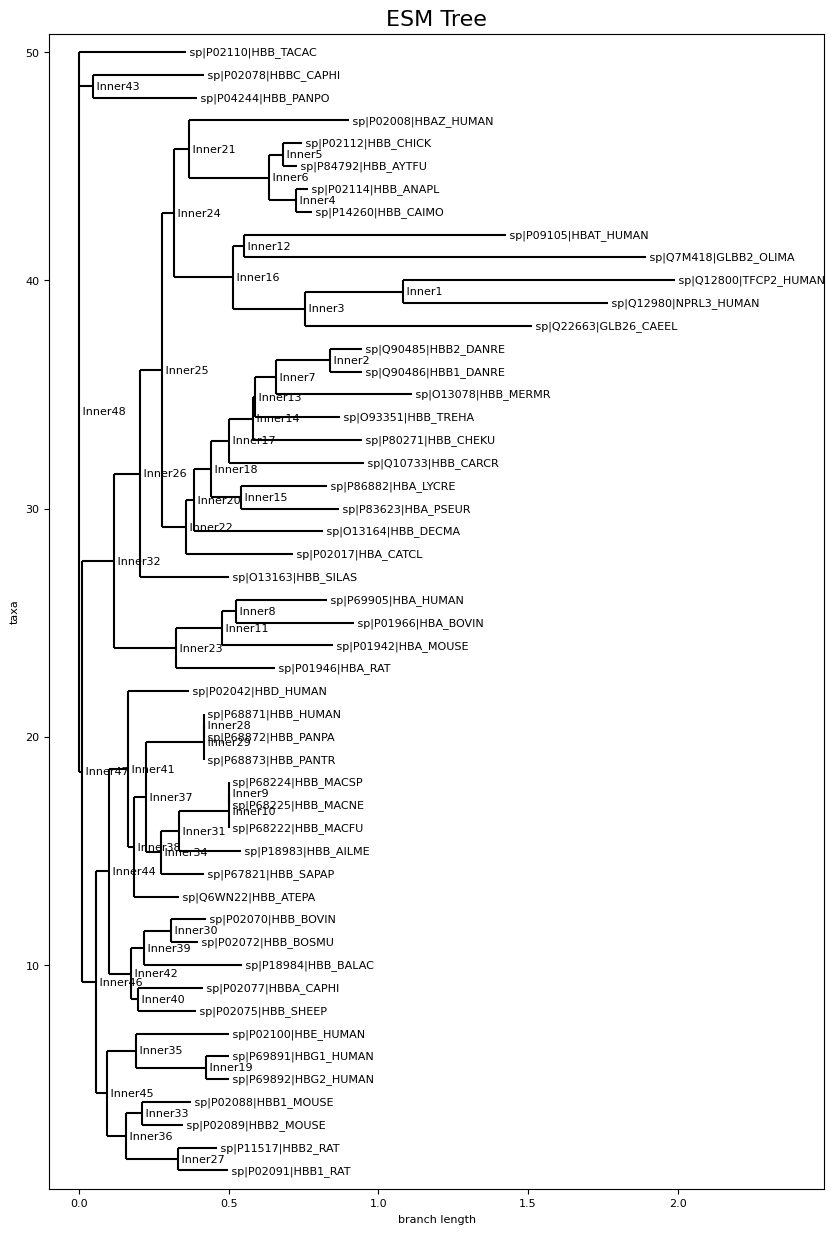

Tree saved in Newick format as: esm_upgma_tree.newick


In [39]:
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from Bio import Phylo
import matplotlib.pyplot as plt

# Step 1: Prepare taxa names
taxa = [seq[0] for seq in sequences]  # Use sequence IDs as taxa labels

# Step 2: Convert full distance matrix to lower triangular format
lower_triangle_matrix = [
    [distance_matrix[i][j] for j in range(i + 1)]
    for i in range(len(distance_matrix))
]

# Create Biopython DistanceMatrix
bio_distance_matrix = DistanceMatrix(taxa, lower_triangle_matrix)

# Step 3: Construct the UPGMA tree
constructor = DistanceTreeConstructor()
upgma_tree = constructor.nj(bio_distance_matrix)

# Step 4: Visualize the tree (north-south layout)
fig, ax = plt.subplots(figsize=(10, 15))  # Adjust figure size for better visibility
Phylo.draw(upgma_tree, axes=ax, do_show=False)  # Draw the tree on the axes
ax.invert_yaxis()  # Flip the tree to make it grow from top to bottom
plt.title("ESM Tree", fontsize=16)
plt.show()

# Step 5: Save the tree in Newick format
tree_file = "esm_upgma_tree.newick"
Phylo.write(upgma_tree, tree_file, "newick")
print(f"Tree saved in Newick format as: {tree_file}")



#  Tried with PFAM database unsuccessfully

In [ ]:
# Second cell - Import libraries and define functions
import requests
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import subprocess
import tempfile
from google.colab import files
import matplotlib.pyplot as plt
import io
import os
import urllib3
from io import StringIO
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [ ]:
def fetch_pfam_sequences(pfam_id):
    """Download sequences from Pfam for a given family ID using REST API"""
    # Using the REST API endpoint
    url = f"https://rest.ensembl.org/family/id/{pfam_id}?content-type=application/json"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()

            # Extract sequences and create FASTA format
            sequences = []
            for member in data.get('members', []):
                seq_id = member.get('species') + '/' + member.get('id')
                sequence = member.get('sequence')
                if sequence:
                    sequences.append(f">{seq_id}\n{sequence}\n")

            if not sequences:
                raise ValueError("No sequences found in the response")

            # Save sequences to a FASTA file
            fasta_content = "".join(sequences)
            with tempfile.NamedTemporaryFile(mode='w', suffix='.fasta', delete=False) as temp_file:
                temp_file.write(fasta_content)
                return temp_file.name
        else:
            print(f"HTTP Status Code: {response.status_code}")
            raise ValueError(f"Failed to fetch sequences: Status code {response.status_code}")

    except Exception as e:
        print(f"Error during download: {str(e)}")
        raise

def realign_sequences(fasta_file):
    """Realign sequences using MAFFT via subprocess"""
    output_file = fasta_file.replace('.fasta', '_aligned.fasta')

    # Run MAFFT using subprocess
    cmd = ['mafft', '--auto', fasta_file]
    try:
        result = subprocess.run(cmd,
                              capture_output=True,
                              text=True,
                              check=True)

        # Write the aligned sequences to file
        with open(output_file, 'w') as handle:
            handle.write(result.stdout)

        return output_file

    except subprocess.CalledProcessError as e:
        print(f"MAFFT alignment failed: {e}")
        print(f"MAFFT error output: {e.stderr}")
        raise
    except Exception as e:
        print(f"An error occurred while running MAFFT: {e}")
        raise

def build_phylogenetic_tree(aligned_fasta):
    """Build phylogenetic tree using distance-based method"""
    alignment = AlignIO.read(aligned_fasta, 'fasta')

    # Calculate distance matrix
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(alignment)

    # Build tree
    constructor = DistanceTreeConstructor()
    tree = constructor.build_tree(dm)

    return tree

def visualize_tree(tree):
    """Create and display a matplotlib figure of the tree"""
    plt.figure(figsize=(20, 20))  # Made figure larger
    Phylo.draw(tree, do_show=False,
               label_func=lambda x: x.name[:30],  # Trim long names
               leaf_font_size=8)  # Smaller font for leaf labels
    plt.title("Protein Family Phylogenetic Tree")
    plt.axis('off')
    plt.show()

def analyze_pfam_family(pfam_id):
    """Main workflow function"""
    try:
        # Download sequences
        print(f"Downloading sequences for {pfam_id}...")
        fasta_file = fetch_pfam_sequences(pfam_id)

        # Print some information about the downloaded sequences
        with open(fasta_file, 'r') as f:
            seq_count = sum(1 for line in f if line.startswith('>'))
        print(f"\nNumber of sequences downloaded: {seq_count}")

        # Realign using MAFFT
        print("\nRealigning sequences...")
        aligned_file = realign_sequences(fasta_file)

        # Build tree
        print("\nBuilding phylogenetic tree...")
        tree = build_phylogenetic_tree(aligned_file)

        # Save tree to Newick format
        tree_file = f"{pfam_id}_tree.newick"
        Phylo.write(tree, tree_file, 'newick')
        print(f"\nTree saved as {tree_file}")

        # Visualize tree
        print("\nGenerating tree visualization...")
        visualize_tree(tree)

        # Download files
        print("\nPreparing files for download...")
        files.download(tree_file)
        files.download(aligned_file)

        # Cleanup temporary files
        if os.path.exists(fasta_file):
            os.remove(fasta_file)

    except Exception as e:
        print(f"Error: {str(e)}")

In [ ]:
# Try with different protein families
protein_families = [
    "PF00042",  # Globin
    "PF00069",  # Protein kinase domain
    "PF00071"   # Ras family
]

for pfam_id in protein_families:
    print(f"\nAnalyzing {pfam_id}...")
    analyze_pfam_family(pfam_id)


Analyzing PF00042...
HTTP Status Code: 404
Error during download: Failed to fetch sequences: Status code 404
Error: Failed to fetch sequences: Status code 404

Analyzing PF00069...
HTTP Status Code: 404
Error during download: Failed to fetch sequences: Status code 404
Error: Failed to fetch sequences: Status code 404

Analyzing PF00071...
HTTP Status Code: 404
Error during download: Failed to fetch sequences: Status code 404
Error: Failed to fetch sequences: Status code 404
